# X3D (eXpanded 3D) Implementation - Design Alternative 1

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error, sige ka magla-lag yang pc mo

`Remarks`: Yeyyyyy panalo raw toh sa Sensiitivity Analysis

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


`Note`: Implementation is taken from [Video classification with a 3D convolutional neural network](https://www.tensorflow.org/tutorials/video/video_classification)

## Create the dataset

#### Import Libraries and Configure Device

In [1]:
## Uncomment if you are running on colab

#!pip install keras-tuner imageio opencv-python tqdm seaborn scikit-learn
#!pip install -q git+https://github.com/tensorflow/docs

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

`Note`: Starting now, we will be using our own dataset to train the model

In [1]:
from tqdm import tqdm
import random
import pathlib
import math
import os
import time

import shutil
import cv2
import mediapipe as mp
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow_docs.vis import embed
import tensorflow as tf
import keras
from keras import layers

2024-12-26 22:52:56.334649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735224777.063734  642216 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735224777.271722  642216 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 22:52:59.284840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Limit usage of VRAM to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_virtual_device_configuration(gpu,
                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5820)])

`Note`: Ikaw bahala sa pag lagay ng memory limit, check your gpu specs and refer to that specs when changing.

#### Visualize the data first

In [3]:
def visulize_data(fil_dir):
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)),
                                  len(all_class_names)-random.randrange(1, len(all_class_names)))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

#### Loading of dataset

In [4]:
## Define the dimensions of frames in the set of frames created (Default params muna)
HEIGHT = 224
WIDTH = 224
SEQUENCE_LENGTH = 10 # small frame raw para small memory at computation ang gawin, ndi kakakayanin ng mga nasa 16GB lang.
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress'
          ])

- `Note`: This can be changed later on once model is okay

In [5]:
def balance_dataset_before_split(dataset_dir):
    """
    Balance the number of files in each folder before splitting by randomly deleting excess files
    to match the lowest count.
    """
    print("\nBalancing dataset...")
    dataset_dir = pathlib.Path(dataset_dir)

    # Get all class subdirectories
    class_dirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
    
    # Count the number of files in each class directory
    file_counts = {class_dir: len(list(class_dir.iterdir())) for class_dir in class_dirs}
    
    # Find the lowest file count
    lowest_count = min(file_counts.values())
    
    print(f"Lowest file count across classes: {lowest_count}")

    # Balance each class directory
    for class_dir, count in file_counts.items():
        if count > lowest_count:
            excess_files = random.sample(list(class_dir.iterdir()), count - lowest_count)
            for file in tqdm(excess_files, desc=f"Balancing {class_dir.name}", unit="file"):
                file.unlink()

def split_dataset(dataset_dir, 
                  splits={"train": 0.7, "val": 0.15, "test": 0.15}, 
                  seed=42, 
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Ensures no data duplication across splits.
    """
    random.seed(seed)
    
    # Convert dataset directory to Path object
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]

    # Balance the dataset before splitting
    balance_dataset_before_split(dataset_dir)

    # Remove existing split directories to avoid data overlap
    for split in splits_dirs:
        split_dir = dataset_dir / split
        if split_dir.exists():
            shutil.rmtree(split_dir)

    # Iterate over each class folder in the dataset
    class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]
    
    # Filter classes if `selected_classes` is provided
    if selected_classes:
        class_dirs = [f for f in class_dirs if f.name in selected_classes]
    
    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"):
        print(f"\nProcessing class: {class_dir.name}")
        
        # Get a list of video files in the class directory
        video_files = [f for f in class_dir.iterdir() if f.is_file()]
        
        random.shuffle(video_files)
        
        num_videos = len(video_files)
        train_end = int(splits["train"] * num_videos)
        val_end = train_end + int(splits["val"] * num_videos)
        
        # Split the video files into train, val, and test 
        train_files = video_files[:train_end]
        val_files = video_files[train_end:val_end]
        test_files = video_files[val_end:]
        
        # Move files to directories (train, val, test)
        for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
            split_dir = dataset_dir / split / class_dir.name
            split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory
            
            for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                shutil.move(str(file), str(split_dir / file.name))
    
    print("\nDataset split complete!")

In [6]:
## File path
file_path = './PD_dataset/' 

In [7]:
## Split the dataset, if na-run na ng isang beses wag na i-run ule, dahil sa code na hindi pa naayos, mawawala lahat yan since na split na si dataset
#split_dataset(file_path, splits={"train": 0.7, "val": 0.15, "test": 0.15}, selected_classes=LABELS) 

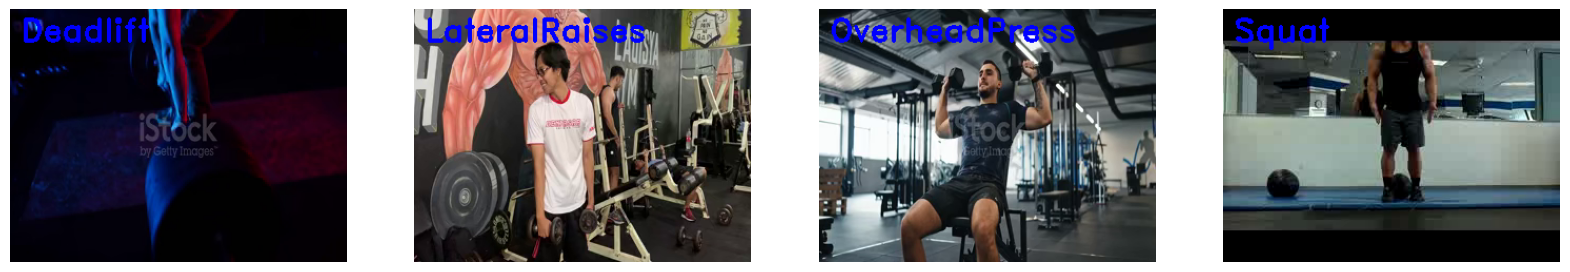

In [8]:
visulize_data(file_path + 'train/')

In [9]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.PosixPath(f'{file_path}train'),
                    'val':pathlib.PosixPath(f'{file_path}val'),
                    'test':pathlib.PosixPath(f'{file_path}test')}

#### Create Frames from each video

In [10]:
def augment_frames(frames, max_brightness_delta=0.2, contrast_lower=0.8, contrast_upper=1.2, saturation_lower=0.8, saturation_upper=1.2):
    # Perform augmentations on the whole batch of frames
    frames = tf.image.random_flip_left_right(frames)  # Random horizontal flip
    frames = tf.image.random_flip_up_down(frames)  # Random vertical flip
    
    frames = tf.image.random_brightness(frames, max_delta=max_brightness_delta)
    frames = tf.image.random_contrast(frames, lower=contrast_lower, upper=contrast_upper)
    frames = tf.image.random_saturation(frames, lower=saturation_lower, upper=saturation_upper)

    return frames

In [11]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  frame = (frame - 0.5) / 0.5  # Adjust to range [-1, 1], to normalize the frame
  return frame

In [12]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224)):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(1, video_length // n_frames)

    if video_length <= n_frames:
        start = 0
    else:
        max_start = video_length - n_frames * frame_step
        start = random.randint(0, max_start)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    if ret:
        result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            result.append(format_frames(frame, output_size))
        else:
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

In [13]:
class FrameGenerator:
    def __init__(self, path, n_frames, training=False, augment=False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.augment = augment
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi')) # Mag .avi na lang since mas maganda raw sabi ni google
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames, output_size=(HEIGHT, WIDTH))
            if self.augment and self.training:
                video_frames = augment_frames(video_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

In [14]:
def configure_dataset(dataset_path, n_frames, batch_size=2, training=False, augment=False):
    frame_gen = FrameGenerator(dataset_path, n_frames, training=training, augment=augment)
    output_signature = (
        tf.TensorSpec(shape=(SEQUENCE_LENGTH, HEIGHT, WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
    ds = tf.data.Dataset.from_generator(frame_gen, output_signature=output_signature)
    if training:
        ds = ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

#### Split and Generate the datasets

In [15]:
train_ds = configure_dataset(dataset_paths['train'], SEQUENCE_LENGTH, training=True)

# Create the training set
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

I0000 00:00:1735224811.539905  642216 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5820 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6
2024-12-26 22:53:41.939821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 55 of 1000
2024-12-26 22:53:51.975707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 121 of 1000
2024-12-26 22:54:11.904941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 243 of 1000


Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)


2024-12-26 22:54:20.522036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [17]:
val_ds = configure_dataset(dataset_paths['test'], SEQUENCE_LENGTH, training=False)

# Create the training set
val_frames, val_labels = next(iter(val_ds))
print(f'Shape of training set of frames: {val_frames.shape}')
print(f'Shape of training labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

#### Plotting Functions for later

In [18]:
def plot_history(history):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

In [19]:
def get_actual_predicted_labels(dataset, trained_model):
    """
        Create a list of actual ground truth values and the predictions from the model.

        Args:
        dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

        Return:
        Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = trained_model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [20]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
      Calculate the precision and recall of a classification model using the ground truth and
      predicted values.

      Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.

      Return:
        Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
      col = cm[:, i]
      fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

      row = cm[i, :]
      fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

      precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

      recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

In [21]:
def calculate_f1_score(y_actual, y_pred, labels, average='macro'):
    """
    Calculate F1-Score for each class and optionally a macro-average.

    Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.
        average: 'macro' to return average F1-score, 'none' to return per-class F1-score.

    Returns:
        A dictionary of F1-Scores per class and/or the macro-average F1-Score.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # True positives (diagonal of confusion matrix)
    precision = tp / (np.sum(cm, axis=0) + 1e-7)  # Avoid division by zero
    recall = tp / (np.sum(cm, axis=1) + 1e-7)

    f1_scores = {label: 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-7)
                 for i, label in enumerate(labels)}

    if average == 'macro':
        macro_f1 = np.mean(list(f1_scores.values()))
        return f1_scores, macro_f1

    return f1_scores

In [22]:
from sklearn.metrics import average_precision_score

def calculate_map(y_actual, y_pred, num_classes):
    """
    Calculate the Mean Average Precision (mAP) for multi-class classification.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        num_classes: The number of classes in the dataset.

    Returns:
        map_score: The Mean Average Precision score.
    """
    # Convert the actual labels to one-hot encoding for mAP calculation
    y_actual_one_hot = np.eye(num_classes)[y_actual]
    
    aps = []
    for i in range(num_classes):
        # Average precision for each class (using one-vs-rest strategy)
        ap = average_precision_score(y_actual_one_hot[:, i], y_pred[:, i])
        aps.append(ap)

    map_score = np.mean(aps)
    return map_score

In [23]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_actual, y_pred, labels):
    """
    Plot Precision-Recall curve and calculate AUC for each class.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        labels: List of class names.

    Returns:
        auc_scores: Dictionary of AUC-PR for each class.
    """
    auc_scores = {}
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(labels):
        # Calculate Precision and Recall values for each class
        precision, recall, _ = precision_recall_curve(y_actual == i, y_pred[:, i])
        pr_auc = auc(recall, precision)
        auc_scores[label] = pr_auc

        # Plot the precision-recall curve for each class
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_scores

## Model Structuring, HyperTuning, and Training

This Network Architecture is from the paper [X3D: Expanding Architectures for Efficient Video Recognition](https://arxiv.org/abs/2004.04730)

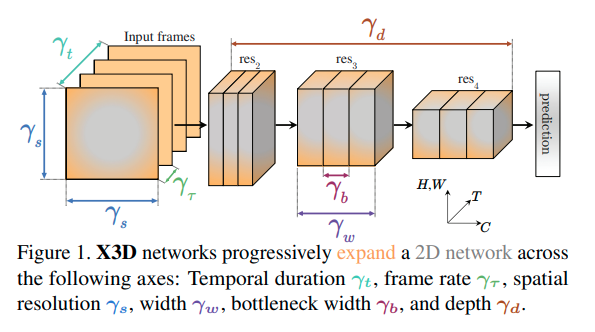

- `Note`: The structure of the is based on the figure above, it will be modified to tailor our project design's specific objectives

Code was inspired from the GutHub repo: https://github.com/facebookresearch/pytorchvideo/blob/main/pytorchvideo/models/x3d.py

#### Network Building and HyperTuning of Parameters

In [24]:
# Squeeze-and-Excitation (SE) Block 
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling3D()(input_tensor)
    se = layers.Dense(filters // reduction, activation='relu', 
                      kernel_regularizer=keras.regularizers.l2(0.01))(se)  # L2 Regularization
    se = layers.Dense(filters, activation='sigmoid', 
                      kernel_regularizer=keras.regularizers.l2(0.01))(se)  # L2 Regularization
    return layers.Multiply()([input_tensor, se])

# 2+1D Convolution Helper (for temporal and spatial convolutions) 
def conv2plus1d(input_tensor, out_channels, kernel_size, stride):
    # Temporal convolution (1x1x1 kernel)
    x = layers.Conv3D(filters=out_channels, kernel_size=(kernel_size[0], 1, 1),
                      strides=(stride[0], 1, 1), padding='same', use_bias=False,
                      kernel_regularizer=keras.regularizers.l2(0.01))(input_tensor)  # L2 Regularization
    x = layers.ReLU()(x)
    
    # Spatial convolution (1xkxk kernel)
    x = layers.Conv3D(filters=out_channels, kernel_size=(1, kernel_size[1], kernel_size[2]),
                      strides=(1, stride[1], stride[2]), padding='same', use_bias=False,
                      kernel_regularizer=keras.regularizers.l2(0.01))(x)  # L2 Regularization
    return x

# X3D Stem Layer with Dropout and L2 Regularization
def create_x3d_stem_tf(input_tensor, out_channels=64, kernel_size=(5, 3, 3), stride=(1, 2, 2), norm=layers.BatchNormalization):
    x = layers.Conv3D(filters=out_channels, kernel_size=(1, kernel_size[1], kernel_size[2]),
                      strides=(1, stride[1], stride[2]), padding='same', use_bias=False,
                      kernel_regularizer=keras.regularizers.l2(0.01))(input_tensor)  # L2 Regularization
    x = norm()(x)
    x = layers.ReLU()(x)

    # Dropout after first convolution
    x = layers.Dropout(0.4)(x) 

    # Second Conv3D (1x1x1) to process the temporal dimension
    x = layers.Conv3D(filters=out_channels, kernel_size=(kernel_size[0], 1, 1), strides=(stride[0], 1, 1),
                      padding='same', use_bias=False, groups=out_channels,
                      kernel_regularizer=keras.regularizers.l2(0.01))(x)  # L2 Regularization
    x = norm()(x)
    x = layers.ReLU()(x)

    return x

# X3D Residual Block with SE Integration and Dropout
def create_x3d_res_block(input_tensor, out_channels, kernel_size, stride, bottleneck=False, reduction=16, norm=layers.BatchNormalization):
    identity = input_tensor
    
    # Adjust the identity if the number of channels or spatial dimensions do not match
    if input_tensor.shape[-1] != out_channels or stride != (1, 1, 1):
        identity = layers.Conv3D(filters=out_channels, kernel_size=1, strides=stride, padding='same',
                                 use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01))(identity)  # L2 Regularization
        identity = norm()(identity)

    x = input_tensor
    if bottleneck:
        # Bottleneck - Reduce the channel size to out_channels // 2
        x = layers.Conv3D(filters=out_channels // 2, kernel_size=1, padding='same', use_bias=False,
                          kernel_regularizer=keras.regularizers.l2(0.01))(x)  # L2 Regularization
        x = norm()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(0.4)(x)  # Dropout after bottleneck

    # Main convolution (spatial + temporal)
    x = conv2plus1d(x, out_channels, kernel_size, stride)
    
    if bottleneck:
        # Bottleneck - Expand back to out_channels
        x = layers.Conv3D(filters=out_channels, kernel_size=1, padding='same', use_bias=False,
                          kernel_regularizer=keras.regularizers.l2(0.01))(x)  # L2 Regularization
        x = norm()(x)

    # Apply SE block to the output of the convolutional layers
    x = se_block(x, reduction)

    # Add the identity to the output (skip connection)
    x = layers.Add()([x, identity])
    return layers.ReLU()(x)

In [25]:
input_shape = (None, SEQUENCE_LENGTH, HEIGHT, WIDTH, 3)
num_classes = len(LABELS)
input_tensor = keras.Input(shape=input_shape[1:])

# Stem Layer
x = create_x3d_stem_tf(input_tensor, out_channels=64)

# First Residual Block (Bottleneck)
x = create_x3d_res_block(x, out_channels=64, kernel_size=(3, 3, 3), stride=(1, 2, 2), bottleneck=True)

# Second Residual Block
x = create_x3d_res_block(x, out_channels=128, kernel_size=(3, 3, 3), stride=(1, 2, 2))

# More Residual Blocks
x = create_x3d_res_block(x, out_channels=256, kernel_size=(3, 3, 3), stride=(1, 2, 2))
x = create_x3d_res_block(x, out_channels=256, kernel_size=(3, 3, 3), stride=(1, 2, 2))
x = create_x3d_res_block(x, out_channels=512, kernel_size=(3, 3, 3), stride=(1, 2, 2))

# Global Average Pooling
x = layers.GlobalAveragePooling3D()(x)

# Fully Connected Output Layer
x = layers.Dense(num_classes)(x)

# Create the Model
x3d_model = keras.Model(inputs=input_tensor, outputs=x)

In [26]:
x3d_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [27]:
frames, label = next(iter(train_ds))
x3d_model.build(frames)
x3d_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 10, 112,   │      1,728 │ input_layer[0][0] │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 112,   │        256 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 10, 112,   │          0 │ batch_normalizat… │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 112,   │          0 │ re_lu[0][0]       │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 10, 112,   │        320 │ dropout[0][0]     │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 112,   │        256 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 10, 112,   │          0 │ batch_normalizat… │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 10, 112,   │      2,048 │ re_lu_1[0][0]     │
│                     │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 112,   │        128 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 10, 112,   │          0 │ batch_normalizat… │
│                     │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 112,   │          0 │ re_lu_2[0][0]     │
│                     │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 10, 112,   │      6,144 │ dropout_1[0][0]   │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 10, 112,   │          0 │ conv3d_4[0][0]    │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 10, 56,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 10, 56,    │      4,096 │ conv3d_5[0][0]    │
│                     │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 56,    │        256 │ conv3d_6[0][0]  

 Total params: 4,753,297 (18.13 MB)

 Trainable params: 4,750,417 (18.12 MB)

 Non-trainable params: 2,880 (11.25 KB)

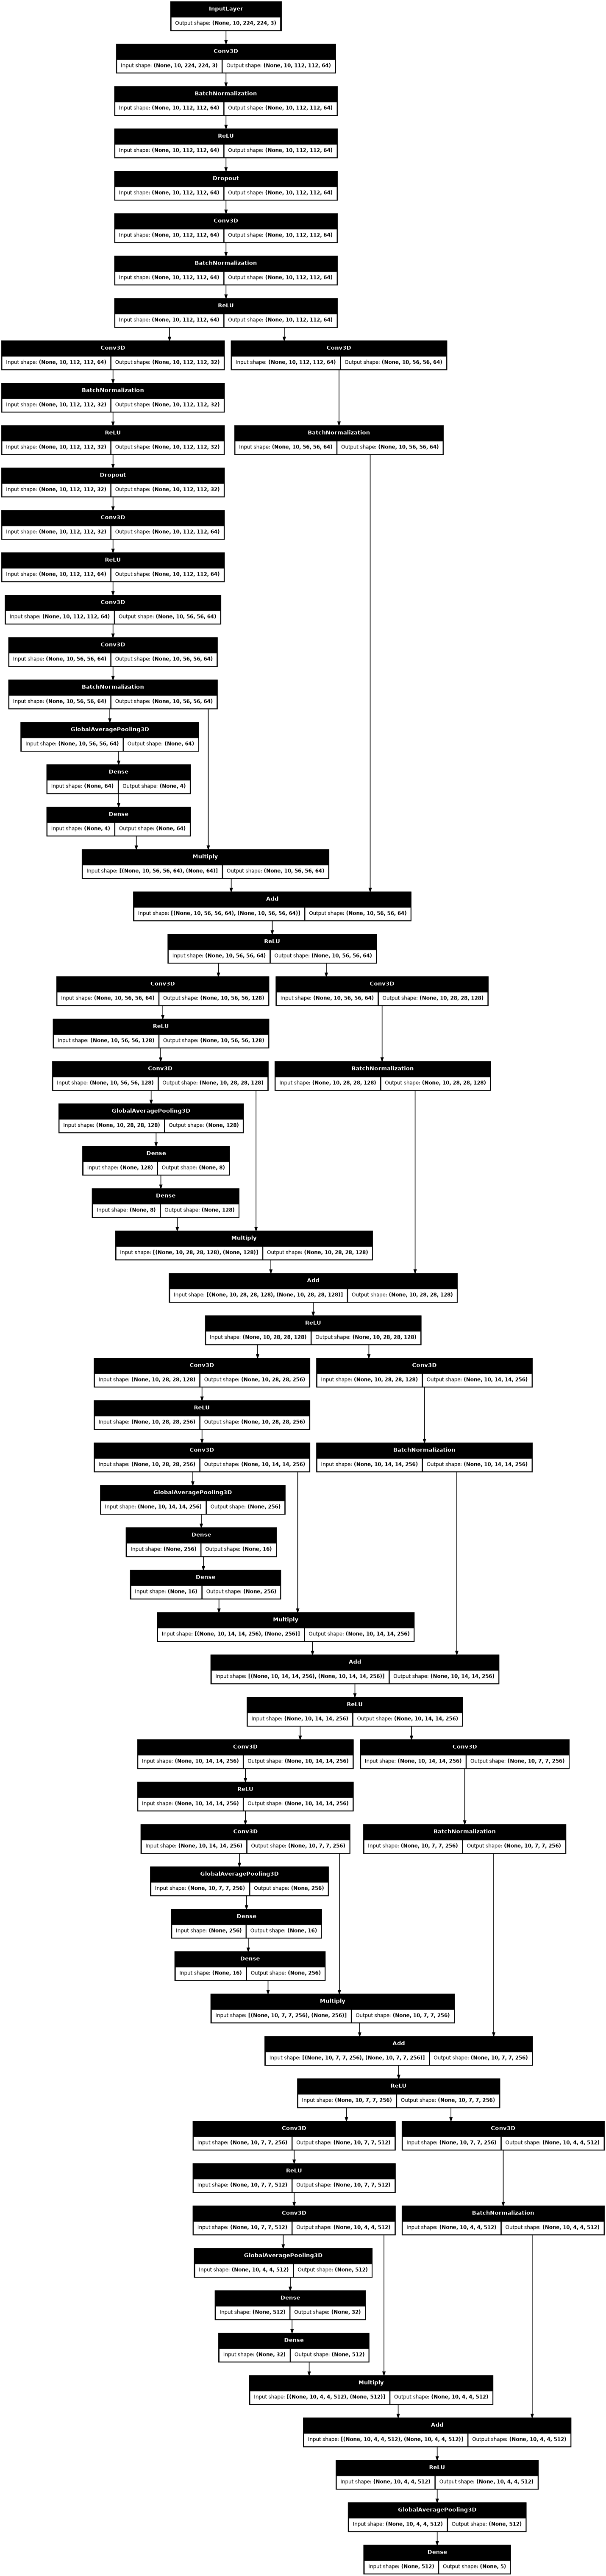

In [28]:
# Visualize the model
keras.utils.plot_model(x3d_model, expand_nested=True, dpi=60, show_shapes=True)

#### Train the model

In [29]:
# Create a callback that saves the model's weights while training

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',        
        patience=30,                
        min_delta=1e-4,            
        restore_best_weights=True
        ),
    keras.callbacks.ModelCheckpoint(
        filepath='model_X3D.keras',       
        save_weights_only=False,           
        save_best_only=True,                
        monitor='val_accuracy',                 
        mode='max'
        ),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

In [ ]:
start_time = time.time()

history_1 = x3d_model.fit(x = train_ds,
                    epochs = 400, # You can change this if you want, ikaw bahala
                    callbacks=callbacks,
                    validation_data = val_ds)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Total training time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds")

Epoch 1/400


I0000 00:00:1735225061.024931  642538 service.cc:148] XLA service 0x7f50cc002050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735225061.025140  642538 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-12-26 22:57:41.347354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735225062.159727  642538 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1735225079.096238  642538 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    153/Unknown 39s 102ms/step - accuracy: 0.1961 - loss: 32.7891

2024-12-26 22:58:14.936881: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-26 22:58:14.936983: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/mnt/d/Documents/vscodeProjects/tfcuda/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
E0000 00:00:1735225096.439546  642538 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735225096.695162  64

153/153 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.1960 - loss: 32.7704 - val_accuracy: 0.2000 - val_loss: 24.6678 - learning_rate: 1.0000e-04
Epoch 2/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2846 - loss: 22.5363

2024-12-26 22:58:50.085706: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-26 22:58:50.085754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 22:58:50.085782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.2845 - loss: 22.5249 - val_accuracy: 0.2714 - val_loss: 17.9585 - learning_rate: 1.0000e-04
Epoch 3/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2555 - loss: 16.4005

2024-12-26 22:58:57.945635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 22:58:57.945673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.2558 - loss: 16.3934 - val_accuracy: 0.2000 - val_loss: 14.6798 - learning_rate: 1.0000e-04
Epoch 4/400


2024-12-26 22:59:10.044897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 22:59:10.044959: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3074 - loss: 12.6024

2024-12-26 22:59:16.049707: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 22:59:16.049741: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041
2024-12-26 22:59:28.240278: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-26 22:59:28.240315: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 22:59:28.240326: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.3076 - loss: 12.5980 - val_accuracy: 0.2857 - val_loss: 11.2963 - learning_rate: 1.0000e-04
Epoch 5/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3198 - loss: 10.2128

2024-12-26 22:59:36.132438: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 22:59:36.132476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.3197 - loss: 10.2102 - val_accuracy: 0.2000 - val_loss: 10.7402 - learning_rate: 1.0000e-04
Epoch 6/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3219 - loss: 8.6882

2024-12-26 22:59:54.193884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 22:59:54.193917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.3219 - loss: 8.6864 - val_accuracy: 0.2429 - val_loss: 8.6355 - learning_rate: 1.0000e-04
Epoch 7/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.5000 - loss: 8.0326

2024-12-26 23:00:05.751924: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:00:05.751973: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3983 - loss: 7.5619

2024-12-26 23:00:11.777091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:00:11.777125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.3982 - loss: 7.5605 - val_accuracy: 0.2571 - val_loss: 8.2318 - learning_rate: 1.0000e-04
Epoch 8/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.0000e+00 - loss: 7.9796

2024-12-26 23:00:23.823331: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:00:23.823381: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3847 - loss: 6.7805

2024-12-26 23:00:29.825419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:00:29.825459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.3848 - loss: 6.7794 - val_accuracy: 0.2571 - val_loss: 7.7030 - learning_rate: 1.0000e-04
Epoch 9/400


2024-12-26 23:00:41.707305: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-26 23:00:41.707348: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:00:41.707369: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4525 - loss: 6.0798

2024-12-26 23:00:47.632625: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:00:47.632668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041
2024-12-26 23:00:59.771448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:00:59.771498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.4524 - loss: 6.0792 - val_accuracy: 0.3143 - val_loss: 6.5542 - learning_rate: 1.0000e-04
Epoch 10/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3665 - loss: 5.7018

2024-12-26 23:01:07.778245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:01:07.778279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.3665 - loss: 5.7012 - val_accuracy: 0.2143 - val_loss: 6.7689 - learning_rate: 1.0000e-04
Epoch 11/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.4591 - loss: 5.2463 - val_accuracy: 0.3143 - val_loss: 5.6787 - learning_rate: 1.0000e-04
Epoch 12/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7500 - loss: 4.5745 

2024-12-26 23:01:37.539299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:01:37.539348: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4702 - loss: 4.8887

2024-12-26 23:01:43.512772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:01:43.512811: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.4702 - loss: 4.8881 - val_accuracy: 0.2000 - val_loss: 6.1770 - learning_rate: 1.0000e-04
Epoch 13/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6944 - loss: 4.6593

2024-12-26 23:01:55.858133: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:01:55.858184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4672 - loss: 4.5873

2024-12-26 23:02:01.912196: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:02:01.912230: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.4671 - loss: 4.5871 - val_accuracy: 0.2714 - val_loss: 5.4867 - learning_rate: 1.0000e-04
Epoch 14/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 1.0000 - loss: 4.1041

2024-12-26 23:02:14.269029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:02:14.269081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5300 - loss: 4.3516

2024-12-26 23:02:20.248072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:02:20.248109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.5292 - loss: 4.3516 - val_accuracy: 0.2857 - val_loss: 4.7854 - learning_rate: 1.0000e-04
Epoch 15/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.6250 - loss: 4.5338

2024-12-26 23:02:32.211240: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:02:32.211296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5478 - loss: 4.0797

2024-12-26 23:02:38.167876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:02:38.167916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.5475 - loss: 4.0793 - val_accuracy: 0.2286 - val_loss: 5.2157 - learning_rate: 1.0000e-04
Epoch 16/400


2024-12-26 23:02:50.091930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:02:50.091980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4284 - loss: 4.0018

2024-12-26 23:02:56.108659: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:02:56.108692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.4286 - loss: 4.0012 - val_accuracy: 0.3000 - val_loss: 5.5822 - learning_rate: 1.0000e-04
Epoch 17/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.5000 - loss: 3.9217

2024-12-26 23:03:08.137817: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-26 23:03:08.137854: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:03:08.137877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.5051 - loss: 3.7700 - val_accuracy: 0.2143 - val_loss: 5.1760 - learning_rate: 1.0000e-04
Epoch 18/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6667 - loss: 3.6900  

2024-12-26 23:03:25.918073: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:03:25.918126: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5363 - loss: 3.6302

2024-12-26 23:03:31.833928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:03:31.833964: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.5361 - loss: 3.6299 - val_accuracy: 0.3143 - val_loss: 4.0985 - learning_rate: 1.0000e-04
Epoch 19/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5814 - loss: 3.3873

2024-12-26 23:03:49.713494: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:03:49.713528: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.5810 - loss: 3.3875 - val_accuracy: 0.3143 - val_loss: 4.6957 - learning_rate: 1.0000e-04
Epoch 20/400


2024-12-26 23:04:01.582865: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:04:01.582915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5178 - loss: 3.2908

2024-12-26 23:04:07.667848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:04:07.667882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041
2024-12-26 23:04:19.510043: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:04:19.510098: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.5180 - loss: 3.2908 - val_accuracy: 0.3429 - val_loss: 5.0738 - learning_rate: 1.0000e-04
Epoch 21/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5756 - loss: 3.1630

2024-12-26 23:04:27.433014: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:04:27.433101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.5754 - loss: 3.1633 - val_accuracy: 0.3000 - val_loss: 4.6875 - learning_rate: 1.0000e-04
Epoch 22/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.5000 - loss: 3.7288

2024-12-26 23:04:39.225990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:04:39.226039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.5774 - loss: 3.1678 - val_accuracy: 0.3429 - val_loss: 4.5969 - learning_rate: 1.0000e-04
Epoch 23/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5125 - loss: 3.0548

2024-12-26 23:05:03.207065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:05:03.207101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.5128 - loss: 3.0545 - val_accuracy: 0.3000 - val_loss: 3.9862 - learning_rate: 1.0000e-04
Epoch 24/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 1.0000 - loss: 2.6785

2024-12-26 23:05:15.648296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:05:15.648354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6109 - loss: 2.8633

2024-12-26 23:05:21.656015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:05:21.656058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.6107 - loss: 2.8635 - val_accuracy: 0.3143 - val_loss: 4.3078 - learning_rate: 1.0000e-04
Epoch 25/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5000 - loss: 3.0228

2024-12-26 23:05:33.827891: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:05:33.827941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.6394 - loss: 2.7831 - val_accuracy: 0.3286 - val_loss: 3.7079 - learning_rate: 1.0000e-04
Epoch 26/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 1.0000 - loss: 2.2532

2024-12-26 23:05:51.831046: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:05:51.831103: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6503 - loss: 2.6575

2024-12-26 23:05:57.785862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:05:57.785898: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.6498 - loss: 2.6582 - val_accuracy: 0.2429 - val_loss: 3.9791 - learning_rate: 1.0000e-04
Epoch 27/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5556 - loss: 2.4228

2024-12-26 23:06:09.743958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:06:09.744006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6946 - loss: 2.5207

2024-12-26 23:06:15.584644: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:06:15.584683: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.6944 - loss: 2.5213 - val_accuracy: 0.2714 - val_loss: 4.1973 - learning_rate: 1.0000e-04
Epoch 28/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.5000 - loss: 2.4191

2024-12-26 23:06:27.857755: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:06:27.857802: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6619 - loss: 2.5847

2024-12-26 23:06:33.801961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:06:33.801994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.6619 - loss: 2.5847 - val_accuracy: 0.3286 - val_loss: 3.4706 - learning_rate: 1.0000e-04
Epoch 29/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.5000 - loss: 2.4677

2024-12-26 23:06:45.729561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:06:45.729610: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6470 - loss: 2.4734

2024-12-26 23:06:51.646270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:06:51.646304: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.6467 - loss: 2.4738 - val_accuracy: 0.2857 - val_loss: 3.4502 - learning_rate: 1.0000e-04
Epoch 30/400


2024-12-26 23:07:03.582165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:07:03.582213: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6624 - loss: 2.4537

2024-12-26 23:07:09.694260: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:07:09.694293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.6621 - loss: 2.4539 - val_accuracy: 0.3429 - val_loss: 3.4388 - learning_rate: 1.0000e-04
Epoch 31/400


2024-12-26 23:07:21.698324: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:07:21.698380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5786 - loss: 2.4580

2024-12-26 23:07:27.836853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:07:27.836903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041
2024-12-26 23:07:39.920038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:07:39.920093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.5788 - loss: 2.4576 - val_accuracy: 0.3571 - val_loss: 3.5097 - learning_rate: 1.0000e-04
Epoch 32/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6063 - loss: 2.4102

2024-12-26 23:07:48.363977: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:07:48.364015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.6064 - loss: 2.4099 - val_accuracy: 0.2286 - val_loss: 3.5580 - learning_rate: 1.0000e-04
Epoch 33/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.5000 - loss: 2.2126

2024-12-26 23:08:00.252081: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-26 23:08:00.252118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:08:00.252140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6651 - loss: 2.2637

2024-12-26 23:08:06.187811: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:08:06.187847: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041
2024-12-26 23:08:17.818198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:08:17.818249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.6650 - loss: 2.2639 - val_accuracy: 0.3714 - val_loss: 3.2949 - learning_rate: 1.0000e-04
Epoch 34/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6758 - loss: 2.2600

2024-12-26 23:08:25.775916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:08:25.775949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.6758 - loss: 2.2599 - val_accuracy: 0.3143 - val_loss: 3.7979 - learning_rate: 1.0000e-04
Epoch 35/400


2024-12-26 23:08:37.767425: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:08:37.767474: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7271 - loss: 2.1314

2024-12-26 23:08:43.764124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:08:43.764161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.7269 - loss: 2.1316 - val_accuracy: 0.2857 - val_loss: 3.4167 - learning_rate: 1.0000e-04
Epoch 36/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 1.0000 - loss: 2.1697

2024-12-26 23:08:55.753905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:08:55.753953: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6958 - loss: 2.1188

2024-12-26 23:09:01.722879: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:09:01.722916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.6958 - loss: 2.1190 - val_accuracy: 0.3143 - val_loss: 3.8662 - learning_rate: 1.0000e-04
Epoch 37/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8750 - loss: 1.9701

2024-12-26 23:09:13.604479: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:09:13.604532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7351 - loss: 2.0721

2024-12-26 23:09:19.409831: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:09:19.409867: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.7350 - loss: 2.0720 - val_accuracy: 0.3143 - val_loss: 3.6954 - learning_rate: 1.0000e-04
Epoch 38/400
  4/153 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6667 - loss: 2.0825

2024-12-26 23:09:31.083821: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:09:31.083871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7103 - loss: 1.9870

2024-12-26 23:09:37.011965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:09:37.012005: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.7100 - loss: 1.9876 - val_accuracy: 0.3143 - val_loss: 3.8497 - learning_rate: 1.0000e-04
Epoch 39/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6934 - loss: 2.0587

2024-12-26 23:09:55.082034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:09:55.082071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.6935 - loss: 2.0585 - val_accuracy: 0.3143 - val_loss: 3.6862 - learning_rate: 5.0000e-05
Epoch 40/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 1.0000 - loss: 1.5092

2024-12-26 23:10:07.240222: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8130 - loss: 1.8660

2024-12-26 23:10:13.231033: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:10:13.231067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8129 - loss: 1.8662 - val_accuracy: 0.3571 - val_loss: 3.3472 - learning_rate: 5.0000e-05
Epoch 41/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8750 - loss: 1.9717

2024-12-26 23:10:25.193190: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:10:25.193250: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.7021 - loss: 1.9666 - val_accuracy: 0.3429 - val_loss: 3.5068 - learning_rate: 5.0000e-05
Epoch 42/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 1.0000 - loss: 1.7620

2024-12-26 23:10:43.405036: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:10:43.405087: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7966 - loss: 1.8686

2024-12-26 23:10:49.345349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:10:49.345382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041
2024-12-26 23:11:01.129732: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:11:01.129781: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7964 - loss: 1.8688 - val_accuracy: 0.4143 - val_loss: 3.0636 - learning_rate: 5.0000e-05
Epoch 43/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7999 - loss: 1.8356

2024-12-26 23:11:09.109832: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:11:09.109878: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.7998 - loss: 1.8356 - val_accuracy: 0.3714 - val_loss: 3.5610 - learning_rate: 5.0000e-05
Epoch 44/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 1.0000 - loss: 1.4733

2024-12-26 23:11:21.157237: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:11:21.157288: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8134 - loss: 1.7398

2024-12-26 23:11:27.096475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:11:27.096516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8132 - loss: 1.7402 - val_accuracy: 0.3429 - val_loss: 3.1313 - learning_rate: 5.0000e-05
Epoch 45/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 1.0000 - loss: 1.5572

2024-12-26 23:11:39.107306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:11:39.107354: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7768 - loss: 1.8062

2024-12-26 23:11:45.086466: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:11:45.086502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.7768 - loss: 1.8061 - val_accuracy: 0.3571 - val_loss: 3.4039 - learning_rate: 5.0000e-05
Epoch 46/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.5000 - loss: 2.2275

2024-12-26 23:11:56.944101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:11:56.944155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8003 - loss: 1.7631

2024-12-26 23:12:02.827298: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:12:02.827333: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8002 - loss: 1.7632 - val_accuracy: 0.3714 - val_loss: 3.4361 - learning_rate: 5.0000e-05
Epoch 47/400


2024-12-26 23:12:14.933051: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:12:14.933107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8289 - loss: 1.7606

2024-12-26 23:12:20.936586: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:12:20.936622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8287 - loss: 1.7607 - val_accuracy: 0.3286 - val_loss: 3.3782 - learning_rate: 5.0000e-05
Epoch 48/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 1.0000 - loss: 1.3655 

2024-12-26 23:12:32.917491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:12:32.917543: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8719 - loss: 1.6429

2024-12-26 23:12:38.932819: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:12:38.932872: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.8716 - loss: 1.6433 - val_accuracy: 0.3857 - val_loss: 3.2175 - learning_rate: 2.5000e-05
Epoch 49/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5000 - loss: 2.2439

2024-12-26 23:12:51.189568: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:12:51.189618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8609 - loss: 1.6274

2024-12-26 23:12:57.064566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:12:57.064607: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041
2024-12-26 23:13:08.865349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:13:08.865398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8609 - loss: 1.6274 - val_accuracy: 0.4286 - val_loss: 3.2248 - learning_rate: 2.5000e-05
Epoch 50/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8056 - loss: 1.6330

2024-12-26 23:13:16.791979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:13:16.792012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.8058 - loss: 1.6329 - val_accuracy: 0.4286 - val_loss: 3.3536 - learning_rate: 2.5000e-05
Epoch 51/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.7500 - loss: 1.4751 

2024-12-26 23:13:28.060638: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:13:28.060688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8386 - loss: 1.6093

2024-12-26 23:13:33.987318: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:13:33.987359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8389 - loss: 1.6092 - val_accuracy: 0.4143 - val_loss: 3.1922 - learning_rate: 2.5000e-05
Epoch 52/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8056 - loss: 1.6406

2024-12-26 23:13:45.932135: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:13:45.932182: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7753 - loss: 1.7278

2024-12-26 23:13:51.833337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:13:51.833381: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.7759 - loss: 1.7270 - val_accuracy: 0.3429 - val_loss: 3.3334 - learning_rate: 2.5000e-05
Epoch 53/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.6944 - loss: 1.8448

2024-12-26 23:14:03.644405: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:14:03.644455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8354 - loss: 1.6059

2024-12-26 23:14:09.521540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:14:09.521577: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8357 - loss: 1.6058 - val_accuracy: 0.3714 - val_loss: 3.2904 - learning_rate: 1.2500e-05
Epoch 54/400


2024-12-26 23:14:21.392110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:14:21.392157: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9089 - loss: 1.5372

2024-12-26 23:14:27.409642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:14:27.409678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9087 - loss: 1.5373 - val_accuracy: 0.3857 - val_loss: 3.1924 - learning_rate: 1.2500e-05
Epoch 55/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 1.0000 - loss: 1.2756

2024-12-26 23:14:39.510392: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:14:39.510437: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8558 - loss: 1.5953

2024-12-26 23:14:45.396334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:14:45.396368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.8557 - loss: 1.5955 - val_accuracy: 0.4000 - val_loss: 3.1469 - learning_rate: 1.2500e-05
Epoch 56/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.6944 - loss: 1.8309

2024-12-26 23:14:57.537486: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:14:57.537536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8779 - loss: 1.5504

2024-12-26 23:15:03.473526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:15:03.473564: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8778 - loss: 1.5506 - val_accuracy: 0.3571 - val_loss: 3.2559 - learning_rate: 1.2500e-05
Epoch 57/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step - accuracy: 1.0000 - loss: 1.4432

2024-12-26 23:15:15.426334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:15:15.426383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8534 - loss: 1.6213

2024-12-26 23:15:21.383159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:15:21.383192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.8535 - loss: 1.6211 - val_accuracy: 0.3714 - val_loss: 3.3230 - learning_rate: 1.2500e-05
Epoch 58/400
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8909 - loss: 1.5263

2024-12-26 23:15:39.509740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:15:39.509774: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8909 - loss: 1.5264 - val_accuracy: 0.3429 - val_loss: 3.2181 - learning_rate: 1.0000e-05
Epoch 59/400
  2/153 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 1.0000 - loss: 1.5107 

2024-12-26 23:15:51.321783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:15:51.321832: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8689 - loss: 1.5204

2024-12-26 23:15:57.206470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:15:57.206510: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8690 - loss: 1.5203 - val_accuracy: 0.3857 - val_loss: 3.2842 - learning_rate: 1.0000e-05
Epoch 60/400


2024-12-26 23:16:09.007558: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8855 - loss: 1.4984

2024-12-26 23:16:15.012550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:16:15.012585: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8855 - loss: 1.4985 - val_accuracy: 0.4000 - val_loss: 3.1959 - learning_rate: 1.0000e-05
Epoch 61/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.0000e+00 - loss: 2.4590

2024-12-26 23:16:26.826054: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.8368 - loss: 1.5597 - val_accuracy: 0.4000 - val_loss: 3.2427 - learning_rate: 1.0000e-05
Epoch 62/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 1.0000 - loss: 1.3091

2024-12-26 23:16:44.929263: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:16:44.929309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9120 - loss: 1.4576

2024-12-26 23:16:50.845499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:16:50.845532: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9119 - loss: 1.4580 - val_accuracy: 0.3857 - val_loss: 3.3633 - learning_rate: 1.0000e-05
Epoch 63/400


2024-12-26 23:17:02.865967: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:17:02.866024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8556 - loss: 1.5685

2024-12-26 23:17:08.918124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:17:08.918159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8555 - loss: 1.5685 - val_accuracy: 0.3857 - val_loss: 3.3050 - learning_rate: 1.0000e-05
Epoch 64/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 1.0000 - loss: 1.1536

2024-12-26 23:17:20.829252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:17:20.829293: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9020 - loss: 1.4782

2024-12-26 23:17:26.767699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:17:26.767737: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9019 - loss: 1.4785 - val_accuracy: 0.4000 - val_loss: 3.2062 - learning_rate: 1.0000e-05
Epoch 65/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 1.0000 - loss: 1.2716 

2024-12-26 23:17:38.690348: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-26 23:17:38.690392: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8641 - loss: 1.5400

2024-12-26 23:17:44.729498: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:17:44.729540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8641 - loss: 1.5400 - val_accuracy: 0.3857 - val_loss: 3.1789 - learning_rate: 1.0000e-05
Epoch 66/400


2024-12-26 23:17:56.592881: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:17:56.592930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8749 - loss: 1.5127

2024-12-26 23:18:02.565269: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:18:02.565303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8748 - loss: 1.5129 - val_accuracy: 0.4000 - val_loss: 3.1346 - learning_rate: 1.0000e-05
Epoch 67/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6944 - loss: 2.0067 

2024-12-26 23:18:14.466643: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:18:14.466692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8707 - loss: 1.5342

2024-12-26 23:18:20.415917: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:18:20.415952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8707 - loss: 1.5342 - val_accuracy: 0.3857 - val_loss: 3.2207 - learning_rate: 1.0000e-05
Epoch 68/400


2024-12-26 23:18:32.284432: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:18:32.284481: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8704 - loss: 1.5292

2024-12-26 23:18:38.298776: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:18:38.298809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8705 - loss: 1.5290 - val_accuracy: 0.3714 - val_loss: 3.3128 - learning_rate: 1.0000e-05
Epoch 69/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 1.0000 - loss: 1.3152

2024-12-26 23:18:50.129684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:18:50.129733: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8826 - loss: 1.5125

2024-12-26 23:18:56.105914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:18:56.105951: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8826 - loss: 1.5124 - val_accuracy: 0.4143 - val_loss: 3.2106 - learning_rate: 1.0000e-05
Epoch 70/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - accuracy: 1.0000 - loss: 1.3211

2024-12-26 23:19:08.113099: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:19:08.113148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8976 - loss: 1.4717

2024-12-26 23:19:14.099000: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:19:14.099035: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.8976 - loss: 1.4717 - val_accuracy: 0.4000 - val_loss: 3.1909 - learning_rate: 1.0000e-05
Epoch 71/400
  3/153 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8611 - loss: 1.6810

2024-12-26 23:19:26.158502: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:19:26.158548: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9134 - loss: 1.4710

2024-12-26 23:19:32.117912: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:19:32.117942: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9133 - loss: 1.4710 - val_accuracy: 0.3714 - val_loss: 3.2689 - learning_rate: 1.0000e-05
Epoch 72/400
  1/153 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 1.0000 - loss: 1.5644

2024-12-26 23:19:44.223091: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:19:44.223148: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8999 - loss: 1.4897

2024-12-26 23:19:50.114962: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13651603114329868773
2024-12-26 23:19:50.114994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 219655774358904041


- `Remarks`: Why use more than 100 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad!

#### Plot the model and get the metrics

In [ ]:
plot_history(history_1)

In [ ]:
test_ds = configure_dataset(dataset_paths['val'], SEQUENCE_LENGTH, training=False)

# Create the training set
test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validating set of frames: {test_frames.shape}')
print(f'Shape of validating labels: {test_labels.shape}')

In [ ]:
x3d_model.evaluate(test_ds, return_dict=True)

In [ ]:
fg = FrameGenerator(dataset_paths['train'], SEQUENCE_LENGTH, training=True)
labels = list(fg.class_ids_for_name.keys())

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds, x3d_model)
plot_confusion_matrix(actual, predicted, labels, 'training')

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds, x3d_model)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

In [ ]:
recall

## Load Model and Test

In [ ]:
## Load model
load_model = keras.models.load_model('model_X3D.keras')

#### Evaluate the Model

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds, load_model)

In [ ]:
f1_score = calculate_f1_score(actual, predicted, labels)
f1_score[1]

In [ ]:
proba = load_model.predict(test_ds)

In [ ]:
MAP = calculate_map(actual, proba, len(labels))
MAP

In [ ]:
plot_precision_recall_curve(actual, proba, labels)

- Ganto si curve kasi may class imbalance, shhh muna wala pa matinong dataset :)

## Test the Model

#### 1 Window

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/OverheadPress.MOV'

cap = cv2.VideoCapture(file_dir)
frames = []
predicted_label = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Process the frame for pose detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    # Draw keypoints and connections on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=3),
                                  mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
                                  )

    # Resize and prepare frame for prediction
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_resized_frame = resized_frame[:, :, ::-1]
    frames.append(rgb_resized_frame)

    # Add predicted activity label to frame
    display_text = f"Activity: {predicted_label}"
    cv2.putText(frame, display_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3.1, (0, 255, 0), 5, cv2.LINE_AA)

    cv2.imshow('Cam1', frame)

    # Perform prediction for every frames
    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1], nasisira si cv2 pag wala HAHAHA
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, sequence_length, height, width, 3)

        prediction = load_model.predict(frames_array)

        # Update predicted label
        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        frames = []

    # Exit loop on 'q' key press
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### 2 Windowws

In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# MediaPipe setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Parameters
sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/OverheadPressBarbell.mp4'
save_dir = 'images/'  # Directory to save images
image_counter = 0  # Counter to generate unique filenames

# Video capture
cap = cv2.VideoCapture(file_dir)
frames = []
predicted_label = ""
pred_list = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Create a copy of the original frame before any modifications
    raw_frame = frame.copy()

    # Process the frame for pose detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    # Draw keypoints and connections on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=3),
                                  mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
                                  )

    # Resize and prepare frame for prediction
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_resized_frame = resized_frame[:, :, ::-1]
    frames.append(rgb_resized_frame)

    # Add predicted activity label to frame
    display_text = f"{predicted_label}"
    cv2.putText(frame, display_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3.1, (0, 255, 0), 5, cv2.LINE_AA)

    # Stack the raw frame and processed frame horizontally
    combined = np.hstack((raw_frame, frame))
    cv2.imshow('Cam1', combined)

    # Perform prediction for every sequence_length frames and save the frame
    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1]
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, sequence_length, height, width, 3)

        prediction = load_model.predict(frames_array)

        # Update predicted label
        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        pred_list.append(predicted_label)
        
        # Save the combined image
        save_path = f"{save_dir}frame_{image_counter:04d}.jpg"
        cv2.imwrite(save_path, combined)
        print(f"Saved image: {save_path}")
        image_counter += 1

        frames = []

    # Exit loop on 'q' key press
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
set(pred_list)

- `Note:` You may notice that it really is inaccurate, this is because of the dataset, not the model's fault XD. No seriously, magulo talaga dataset namin, may mga videos na putol parts ng katawan kaya hindi masyado naje-generalize ng model.